#Multivariate Linear Regression based Global Mean Sea Level Forecasting

[Jianwu Wang @ UMBC](https://bdal.umbc.edu/people/jianwu/)

June 13, 2022

This notebook demonstrates a machine learning based forecasting of Reconstructed Global Mean Sea Level data 1900-2018 (https://opendap.jpl.nasa.gov/opendap/allData/homage/L4/gmsl/global_timeseries_measures.nc). Additioinal information of the dataset can be found at https://podaac.jpl.nasa.gov/dataset/JPL_RECON_GMSL.

The notebook is an extention of https://github.com/podaac/the-coding-club/blob/main/notebooks/Earthdata_webinar_20220727.ipynb which provides detailed information on how to process Global Mean Sea Level data at AWS cloud. 

Please try notebook https://github.com/podaac/the-coding-club/blob/main/notebooks/Earthdata_webinar_20220727.ipynb to get inital evnronment setup first. Below are steps to run the EC2 instance is stopped and started again.


1.   Accessing your EC2 instance via ssh forwarding: 
```
ssh -i "~/.ssh/aws_ec2_jupyter.pem" ec2-user@The_public_ip_address -L 9889:localhost:9889
```
2.   Activate jupyter environment via Conda
```
source ~/conda/bin/activate && \
conda activate jupyter && \
```
3.   Start jupyter via command line
```
W="$(python3 -c 'from notebook.auth import passwd; import getpass; print(passwd(getpass.getpass(), algorithm="sha256"))')"
jupyter lab --port=9889 --ip='127.0.0.1' --NotebookApp.token='' --NotebookApp.password="$PW" --notebook-dir="$HOME" --no-browser
```
4.  Access the server through your web browser: http://127.0.0.1:9889/ 




In [ ]:
#install via conda: conda sklearn pandas_profiling -y
import xarray as xr
import numpy as np
import pandas as pd
from sklearn import datasets, preprocessing
from sklearn.model_selection import train_test_split
#import pandas_profiling
from matplotlib import pyplot as plt
import sklearn.gaussian_process as gp
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
#from sklearn.gaussian_process import GaussianProcessRegressor
#from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


In [ ]:
d1=xr.open_dataset('https://opendap.jpl.nasa.gov/opendap/allData/homage/L4/gmsl/global_timeseries_measures.nc#mode=bytes')

FileNotFoundError: ignored

In [ ]:

df = pd.read_csv("global_timeseries_measures.csv")
df = df.drop('time', 1)
df


/home/ec2-user/conda/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,global_average_sea_level_change,global_average_sea_level_change_upper,global_average_sea_level_change_lower,glac_mean,glac_upper,glac_lower,GrIS_mean,GrIS_upper,GrIS_lower,AIS_mean,...,AIS_lower,tws_mean,tws_upper,tws_lower,global_average_thermosteric_sea_level_change,global_average_thermosteric_sea_level_change_upper,global_average_thermosteric_sea_level_change_lower,sum_of_contrib_processes_mean,sum_of_contrib_processes_upper,sum_of_contrib_processes_lower
0,-173.26140,-141.00280,-203.557300,-79.553700,-62.50,-95.50,-48.064430,-37.40,-58.80,-9.494853,...,-16.15,12.326830,21.80,2.80,-48.279350,-37.552920,-58.666310,-173.09080,-146.75540,-199.22790
1,-168.80170,-135.89760,-201.018500,-78.703810,-61.80,-94.60,-48.179390,-37.60,-58.95,-9.440325,...,-16.00,15.246700,24.70,5.75,-49.144900,-38.849600,-58.755150,-170.24550,-144.46240,-195.46080
2,-180.39000,-148.21380,-212.074100,-77.843640,-61.20,-93.50,-47.861700,-37.45,-58.65,-9.385606,...,-15.90,16.570810,26.10,7.15,-49.877560,-39.888830,-59.155020,-168.42180,-142.79170,-193.36980
3,-170.26780,-138.93050,-202.697600,-77.272090,-60.55,-92.85,-47.453550,-36.95,-58.20,-9.331830,...,-15.80,16.624290,26.10,7.15,-51.100590,-40.815860,-60.985010,-168.55760,-143.22580,-193.18990
4,-168.72010,-137.45010,-200.167000,-76.430740,-59.80,-91.80,-46.626560,-37.40,-56.20,-9.277636,...,-15.65,16.227050,25.70,6.70,-52.240180,-41.379250,-62.585710,-168.37240,-142.75460,-193.11220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,11.86894,20.25806,3.502924,2.607803,2.80,2.45,3.849548,4.05,3.70,1.770051,...,1.40,-0.759097,-0.05,-1.60,4.670032,5.028707,4.308544,12.16477,13.24838,10.86838
115,17.86952,26.59175,9.216259,3.392661,3.65,3.20,4.429987,4.70,4.20,2.701558,...,2.20,3.344095,4.25,2.30,6.744699,7.239516,5.933526,20.68869,22.15863,18.93830
116,23.94186,32.67299,15.510550,4.098025,4.35,3.85,5.181757,5.50,4.95,2.511931,...,1.90,4.953524,6.00,3.65,6.472463,7.420359,5.686140,23.29217,25.23776,21.12208
117,32.35805,42.67341,22.312290,4.985921,5.35,4.65,5.832570,6.20,5.50,2.652418,...,1.90,2.755220,4.05,1.20,8.048318,8.812847,7.528717,24.34900,26.46899,21.96355


In [ ]:
df.loc[:, 'global_average_sea_level_change_2'] = df['global_average_sea_level_change']
df

,global_average_sea_level_change,global_average_sea_level_change_upper,global_average_sea_level_change_lower,glac_mean,glac_upper,glac_lower,GrIS_mean,GrIS_upper,GrIS_lower,AIS_mean,...,tws_mean,tws_upper,tws_lower,global_average_thermosteric_sea_level_change,global_average_thermosteric_sea_level_change_upper,global_average_thermosteric_sea_level_change_lower,sum_of_contrib_processes_mean,sum_of_contrib_processes_upper,sum_of_contrib_processes_lower,global_average_sea_level_change_2
0,-173.26140,-141.00280,-203.557300,-79.553700,-62.50,-95.50,-48.064430,-37.40,-58.80,-9.494853,...,12.326830,21.80,2.80,-48.279350,-37.552920,-58.666310,-173.09080,-146.75540,-199.22790,-173.26140
1,-168.80170,-135.89760,-201.018500,-78.703810,-61.80,-94.60,-48.179390,-37.60,-58.95,-9.440325,...,15.246700,24.70,5.75,-49.144900,-38.849600,-58.755150,-170.24550,-144.46240,-195.46080,-168.80170
2,-180.39000,-148.21380,-212.074100,-77.843640,-61.20,-93.50,-47.861700,-37.45,-58.65,-9.385606,...,16.570810,26.10,7.15,-49.877560,-39.888830,-59.155020,-168.42180,-142.79170,-193.36980,-180.39000
3,-170.26780,-138.93050,-202.697600,-77.272090,-60.55,-92.85,-47.453550,-36.95,-58.20,-9.331830,...,16.624290,26.10,7.15,-51.100590,-40.815860,-60.985010,-168.55760,-143.22580,-193.18990,-170.26780
4,-168.72010,-137.45010,-200.167000,-76.430740,-59.80,-91.80,-46.626560,-37.40,-56.20,-9.277636,...,16.227050,25.70,6.70,-52.240180,-41.379250,-62.585710,-168.37240,-142.75460,-193.11220,-168.72010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,11.86894,20.25806,3.502924,2.607803,2.80,2.45,3.849548,4.05,3.70,1.770051,...,-0.759097,-0.05,-1.60,4.670032,5.028707,4.308544,12.16477,13.24838,10.86838,11.86894
115,17.86952,26.59175,9.216259,3.392661,3.65,3.20,4.429987,4.70,4.20,2.701558,...,3.344095,4.25,2.30,6.744699,7.239516,5.933526,20.68869,22.15863,18.93830,17.86952
116,23.94186,32.67299,15.510550,4.098025,4.35,3.85,5.181757,5.50,4.95,2.511931,...,4.953524,6.00,3.65,6.472463,7.420359,5.686140,23.29217,25.23776,21.12208,23.94186
117,32.35805,42.67341,22.312290,4.985921,5.35,4.65,5.832570,6.20,5.50,2.652418,...,2.755220,4.05,1.20,8.048318,8.812847,7.528717,24.34900,26.46899,21.96355,32.35805


In [ ]:
#Creating datasets with lag of 1 to 6 months
df1 = df.assign(global_average_sea_level_change_2 = df.global_average_sea_level_change_2.shift(-1)).drop(df.index[-1])
df2 = df1.assign(global_average_sea_level_change_2 = df1.global_average_sea_level_change_2.shift(-1)).drop(df1.index[-1])
df3 = df2.assign(global_average_sea_level_change_2 = df2.global_average_sea_level_change_2.shift(-1)).drop(df2.index[-1])
df4 = df3.assign(global_average_sea_level_change_2 = df3.global_average_sea_level_change_2.shift(-1)).drop(df3.index[-1])
df5 = df4.assign(global_average_sea_level_change_2 = df4.global_average_sea_level_change_2.shift(-1)).drop(df4.index[-1])
df6 = df5.assign(global_average_sea_level_change_2 = df5.global_average_sea_level_change_2.shift(-1)).drop(df5.index[-1])

## 1:

In [ ]:
df1

,global_average_sea_level_change,global_average_sea_level_change_upper,global_average_sea_level_change_lower,glac_mean,glac_upper,glac_lower,GrIS_mean,GrIS_upper,GrIS_lower,AIS_mean,...,tws_mean,tws_upper,tws_lower,global_average_thermosteric_sea_level_change,global_average_thermosteric_sea_level_change_upper,global_average_thermosteric_sea_level_change_lower,sum_of_contrib_processes_mean,sum_of_contrib_processes_upper,sum_of_contrib_processes_lower,global_average_sea_level_change_2
0,-173.261400,-141.00280,-203.557300,-79.553700,-62.50,-95.50,-48.064430,-37.40,-58.80,-9.494853,...,12.326830,21.80,2.80,-48.279350,-37.552920,-58.666310,-173.09080,-146.75540,-199.227900,-168.80170
1,-168.801700,-135.89760,-201.018500,-78.703810,-61.80,-94.60,-48.179390,-37.60,-58.95,-9.440325,...,15.246700,24.70,5.75,-49.144900,-38.849600,-58.755150,-170.24550,-144.46240,-195.460800,-180.39000
2,-180.390000,-148.21380,-212.074100,-77.843640,-61.20,-93.50,-47.861700,-37.45,-58.65,-9.385606,...,16.570810,26.10,7.15,-49.877560,-39.888830,-59.155020,-168.42180,-142.79170,-193.369800,-170.26780
3,-170.267800,-138.93050,-202.697600,-77.272090,-60.55,-92.85,-47.453550,-36.95,-58.20,-9.331830,...,16.624290,26.10,7.15,-51.100590,-40.815860,-60.985010,-168.55760,-143.22580,-193.189900,-168.72010
4,-168.720100,-137.45010,-200.167000,-76.430740,-59.80,-91.80,-46.626560,-37.40,-56.20,-9.277636,...,16.227050,25.70,6.70,-52.240180,-41.379250,-62.585710,-168.37240,-142.75460,-193.112200,-160.98140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,6.370174,14.94265,-2.195722,1.867449,2.05,1.70,3.443771,3.60,3.35,1.079971,...,0.398772,0.90,-0.15,3.112605,3.669379,2.740455,9.97247,10.93161,8.955513,11.86894
114,11.868940,20.25806,3.502924,2.607803,2.80,2.45,3.849548,4.05,3.70,1.770051,...,-0.759097,-0.05,-1.60,4.670032,5.028707,4.308544,12.16477,13.24838,10.868380,17.86952
115,17.869520,26.59175,9.216259,3.392661,3.65,3.20,4.429987,4.70,4.20,2.701558,...,3.344095,4.25,2.30,6.744699,7.239516,5.933526,20.68869,22.15863,18.938300,23.94186
116,23.941860,32.67299,15.510550,4.098025,4.35,3.85,5.181757,5.50,4.95,2.511931,...,4.953524,6.00,3.65,6.472463,7.420359,5.686140,23.29217,25.23776,21.122080,32.35805


In [ ]:
data = np.array(df1)
target = data[:,-1] #assign last column to be target variable
data = data[:,:-1] #dropping last column from features

# print(data.shape)
# print(target.shape)
LEN_DATA = len(data) #total number of pixels
NUM_TRAIN = LEN_DATA - (24+6) #reserve last 30 months for testing



x_train = data[0:NUM_TRAIN]
y_train = target[0:NUM_TRAIN]

x_test = data[NUM_TRAIN:]
y_test=target[NUM_TRAIN:]



In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(data,target,test_size=0.3,) # .target.reshape(-1, 1)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(88, 21)
(88,)
(30, 21)
(30,)


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler_x = MinMaxScaler()
x_train = scaler_x.fit_transform(x_train) 
x_test = scaler_x.transform(x_test) 

scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test = scaler_y.transform(y_test.reshape(-1,1)) 

In [ ]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [ ]:
y_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)

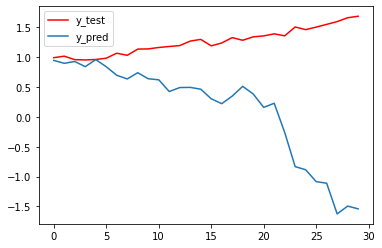

In [ ]:
%matplotlib inline
#plot 
plt.plot(y_test, color='red')
plt.plot(y_pred)

plt.legend(['y_test','y_pred'])
plt.show()


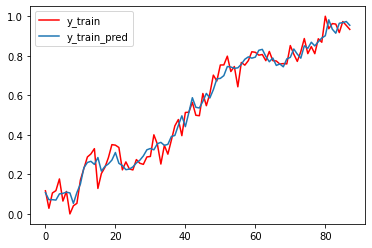

In [ ]:
%matplotlib inline
#plot 
plt.plot(y_train, color='red')
plt.plot(y_train_pred)

plt.legend(['y_train','y_train_pred'])
plt.show()

In [ ]:
#Sample code to inverse transform data
#Inverse transformation should be performed after getting predictions
inv_y_train = scaler_y.inverse_transform(y_train)
inv_y_test = scaler_y.inverse_transform(y_test)
inv_y_pred = scaler_y.inverse_transform(y_pred)


In [ ]:
#Save Test data vs predictions
from tempfile import TemporaryFile

#test_data = np.concatenate((inv_y_valid.reshape(-1,1),inv_testPred.reshape(-1,1)), axis=1)
np_file = TemporaryFile()
np.save('MLR_lag1.npy', inv_y_pred)
_ = np_file.seek(0)

In [ ]:
rmse1 = np.sqrt(np.mean((inv_y_pred - inv_y_test) ** 2))
rmse1

197.35814719517498

In [ ]:
nrmse1 = rmse1/(np.mean(inv_y_test))
nrmse1

-9.879936313953472

In [ ]:
r2_score1 = r2_score(inv_y_test, inv_y_pred)

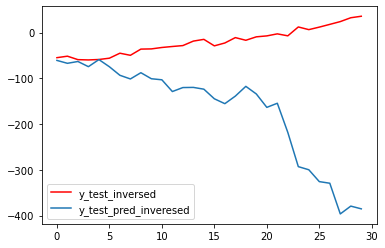

In [ ]:
%matplotlib inline
#plot 
plt.plot(inv_y_test, color='red')
plt.plot(inv_y_pred)

plt.legend(['y_test_inversed','y_test_pred_inveresed'])
plt.show()

## 2

In [ ]:
data = np.array(df2)
target = data[:,-1] #assign last column to be target variable
data = data[:,:-1] #dropping last column from features

LEN_DATA = len(data) #total number of pixels
NUM_TRAIN = LEN_DATA - (24+6) #reserve last 30 months for testing

x_train = data[0:NUM_TRAIN]
y_train = target[0:NUM_TRAIN]

x_test = data[NUM_TRAIN:]
y_test=target[NUM_TRAIN:]


In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(data,target,test_size=0.3,)
 
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(87, 21)
(87,)
(30, 21)
(30,)


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
 
scaler_x = MinMaxScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)
 
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test = scaler_y.transform(y_test.reshape(-1,1))

In [ ]:
model = LinearRegression()
model.fit(x_train, y_train) 

LinearRegression()

In [ ]:
y_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)

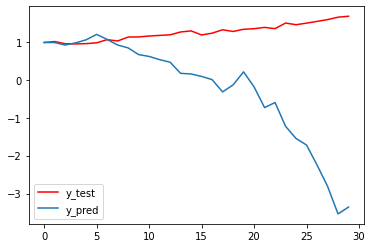

In [ ]:
%matplotlib inline
#plot
plt.plot(y_test, color='red')
plt.plot(y_pred)
 
plt.legend(['y_test','y_pred'])
plt.show()

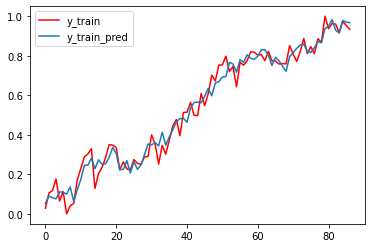

In [ ]:
%matplotlib inline
#plot
plt.plot(y_train, color='red')
plt.plot(y_train_pred)
 
plt.legend(['y_train','y_train_pred'])
plt.show()

In [ ]:
inv_y_train = scaler_y.inverse_transform(y_train)
inv_y_test = scaler_y.inverse_transform(y_test)
inv_y_pred = scaler_y.inverse_transform(y_pred)


In [ ]:
#Save Test data vs predictions
from tempfile import TemporaryFile

#test_data = np.concatenate((inv_y_valid.reshape(-1,1),inv_testPred.reshape(-1,1)), axis=1)
np_file = TemporaryFile()
np.save('MLR_lag2.npy', inv_y_pred)
_ = np_file.seek(0)

In [ ]:
rmse2 = np.sqrt(np.mean((inv_y_pred - inv_y_test) ** 2))

In [ ]:
nrmse2 = rmse2/(np.mean(inv_y_test))
nrmse2

-13.95016165267305

In [ ]:
r2_score2 = r2_score(inv_y_test, inv_y_pred)

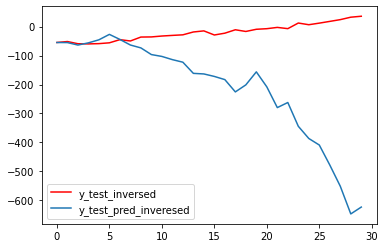

In [ ]:
%matplotlib inline
#plot
plt.plot(inv_y_test, color='red')
plt.plot(inv_y_pred)
 
plt.legend(['y_test_inversed','y_test_pred_inveresed'])
plt.show()


## 3

In [ ]:
data = np.array(df3)
target = data[:,-1] #assign last column to be target variable
data = data[:,:-1] #dropping last column from features

LEN_DATA = len(data) #total number of pixels
NUM_TRAIN = LEN_DATA - (24+6) #reserve last 30 months for testing

x_train = data[0:NUM_TRAIN]
y_train = target[0:NUM_TRAIN]

x_test = data[NUM_TRAIN:]
y_test=target[NUM_TRAIN:]


In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(data,target,test_size=0.3,)
 
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(86, 21)
(86,)
(30, 21)
(30,)


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
 
scaler_x = MinMaxScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)
 
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test = scaler_y.transform(y_test.reshape(-1,1))

In [ ]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [ ]:
y_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)

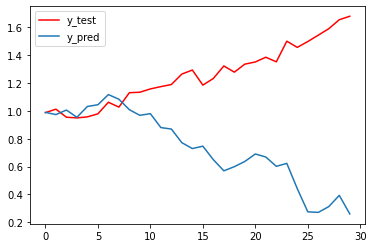

In [ ]:
%matplotlib inline
#plot
plt.plot(y_test, color='red')
plt.plot(y_pred)
 
plt.legend(['y_test','y_pred'])
plt.show()

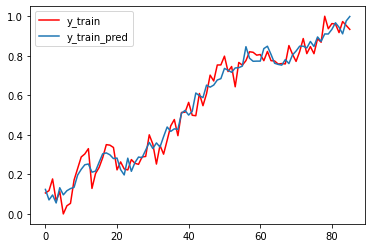

In [ ]:
%matplotlib inline
#plot
plt.plot(y_train, color='red')
plt.plot(y_train_pred)
 
plt.legend(['y_train','y_train_pred'])
plt.show()

In [ ]:
inv_y_train = scaler_y.inverse_transform(y_train)
inv_y_test = scaler_y.inverse_transform(y_test)
inv_y_pred = scaler_y.inverse_transform(y_pred)
 
print(y_train[1]) #print out the scaled value
print(inv_y_train[1]) #print out the inverted/original value

[0.11773513]
[-168.7201]


In [ ]:
#Save Test data vs predictions
from tempfile import TemporaryFile

np_file = TemporaryFile()
np.save('MLR_lag3.npy', inv_y_pred)
_ = np_file.seek(0)

In [ ]:
rmse3 = np.sqrt(np.mean((inv_y_pred - inv_y_test) ** 2))
rmse3

91.148194600544

In [ ]:
nrmse3 = rmse3/(np.mean(inv_y_test))
nrmse3

-4.562965200998953

In [ ]:
r2_score3 = r2_score(inv_y_test, inv_y_pred)

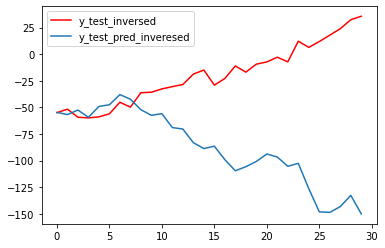

In [ ]:
%matplotlib inline
#plot
plt.plot(inv_y_test, color='red')
plt.plot(inv_y_pred)
 
plt.legend(['y_test_inversed','y_test_pred_inveresed'])
plt.show()


## 4:

In [ ]:
data = np.array(df4)
target = data[:,-1] #assign last column to be target variable
data = data[:,:-1] #dropping last column from features

LEN_DATA = len(data) #total number of pixels
NUM_TRAIN = LEN_DATA - (24+6) #reserve last 30 months for testing

x_train = data[0:NUM_TRAIN]
y_train = target[0:NUM_TRAIN]

x_test = data[NUM_TRAIN:]
y_test=target[NUM_TRAIN:]


In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(data,target,test_size=0.3,)
 
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(85, 21)
(85,)
(30, 21)
(30,)


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
 
scaler_x = MinMaxScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)
 
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test = scaler_y.transform(y_test.reshape(-1,1))

In [ ]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [ ]:
y_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)

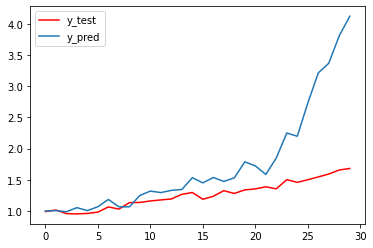

In [ ]:
%matplotlib inline
#plot
plt.plot(y_test, color='red')
plt.plot(y_pred)
 
plt.legend(['y_test','y_pred'])
plt.show()

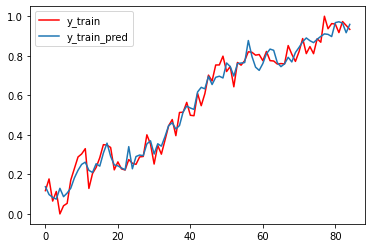

In [ ]:
%matplotlib inline
#plot
plt.plot(y_train, color='red')
plt.plot(y_train_pred)
 
plt.legend(['y_train','y_train_pred'])
plt.show()

In [ ]:
inv_y_train = scaler_y.inverse_transform(y_train)
inv_y_test = scaler_y.inverse_transform(y_test)
inv_y_pred = scaler_y.inverse_transform(y_pred)


In [ ]:
#Save Test data vs predictions
from tempfile import TemporaryFile

#test_data = np.concatenate((inv_y_valid.reshape(-1,1),inv_testPred.reshape(-1,1)), axis=1)
np_file = TemporaryFile()
np.save('MLR_lag4.npy', inv_y_pred)
_ = np_file.seek(0)

In [ ]:
rmse4 = np.sqrt(np.mean((inv_y_pred - inv_y_test) ** 2))
rmse4

107.49386233082606

In [ ]:
nrmse4 = rmse4/(np.mean(inv_y_test))
nrmse4

-5.381244853900859

In [ ]:
r2_score4 = r2_score(inv_y_test, inv_y_pred)

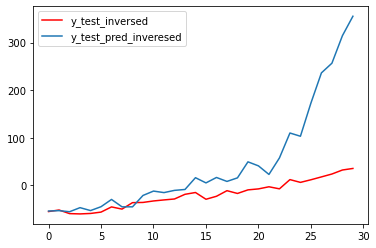

In [ ]:
%matplotlib inline
#plot
plt.plot(inv_y_test, color='red')
plt.plot(inv_y_pred)
 
plt.legend(['y_test_inversed','y_test_pred_inveresed'])
plt.show()


## 5:

In [ ]:
data = np.array(df5)
target = data[:,-1] #assign last column to be target variable
data = data[:,:-1] #dropping last column from features

LEN_DATA = len(data) #total number of pixels
NUM_TRAIN = LEN_DATA - (24+6) #reserve last 30 months for testing

x_train = data[0:NUM_TRAIN]
y_train = target[0:NUM_TRAIN]

x_test = data[NUM_TRAIN:]
y_test=target[NUM_TRAIN:]


In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(data,target,test_size=0.3,)
 
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(84, 21)
(84,)
(30, 21)
(30,)


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
 
scaler_x = MinMaxScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)
 
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test = scaler_y.transform(y_test.reshape(-1,1))

In [ ]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [ ]:
y_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)

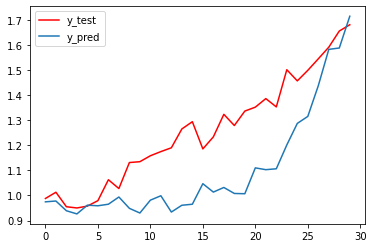

In [ ]:
%matplotlib inline
#plot
plt.plot(y_test, color='red')
plt.plot(y_pred)
 
plt.legend(['y_test','y_pred'])
plt.show()

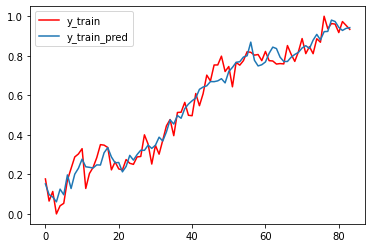

In [ ]:
%matplotlib inline
#plot
plt.plot(y_train, color='red')
plt.plot(y_train_pred)
 
plt.legend(['y_train','y_train_pred'])
plt.show()

In [ ]:
inv_y_train = scaler_y.inverse_transform(y_train)
inv_y_test = scaler_y.inverse_transform(y_test)
inv_y_pred = scaler_y.inverse_transform(y_pred)
 
print(y_train[1]) #print out the scaled value
print(inv_y_train[1]) #print out the inverted/original value

[0.06507083]
[-175.6053]


In [ ]:
#Save Test data vs predictions
from tempfile import TemporaryFile

#test_data = np.concatenate((inv_y_valid.reshape(-1,1),inv_testPred.reshape(-1,1)), axis=1)
np_file = TemporaryFile()
np.save('MLR_lag5.npy', inv_y_pred)
_ = np_file.seek(0)

In [ ]:
rmse5 = np.sqrt(np.mean((inv_y_pred - inv_y_test) ** 2))
rmse5

25.281797759440643

In [ ]:
nrmse5 = rmse5/(np.mean(inv_y_test))
nrmse5

-1.2656308103587215

In [ ]:
r2_score5 = r2_score(inv_y_test, inv_y_pred)

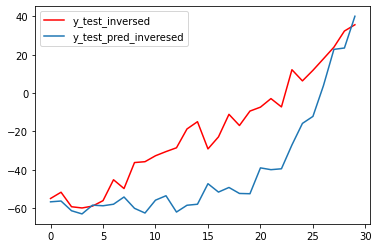

In [ ]:
%matplotlib inline
#plot
plt.plot(inv_y_test, color='red')
plt.plot(inv_y_pred)
 
plt.legend(['y_test_inversed','y_test_pred_inveresed'])
plt.show()


## 6:

In [ ]:
data = np.array(df6)
target = data[:,-1] #assign last column to be target variable
data = data[:,:-1] #dropping last column from features

LEN_DATA = len(data) #total number of pixels
NUM_TRAIN = LEN_DATA - (24+6) #reserve last 30 months for testing

x_train = data[0:NUM_TRAIN]
y_train = target[0:NUM_TRAIN]

x_test = data[NUM_TRAIN:]
y_test=target[NUM_TRAIN:]


In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(data,target,test_size=0.3,)
 
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(83, 21)
(83,)
(30, 21)
(30,)


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
 
scaler_x = MinMaxScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)
 
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test = scaler_y.transform(y_test.reshape(-1,1))

In [ ]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [ ]:
y_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)

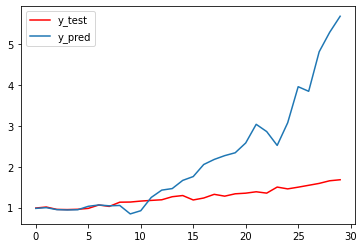

In [ ]:
%matplotlib inline
#plot
plt.plot(y_test, color='red')
plt.plot(y_pred)
 
plt.legend(['y_test','y_pred'])
plt.show()

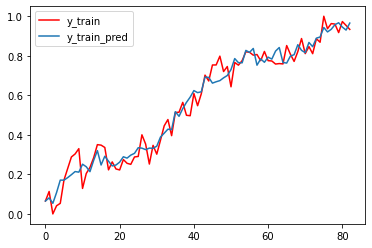

In [ ]:
%matplotlib inline
#plot
plt.plot(y_train, color='red')
plt.plot(y_train_pred)
 
plt.legend(['y_train','y_train_pred'])
plt.show()

In [ ]:
inv_y_train = scaler_y.inverse_transform(y_train)
inv_y_test = scaler_y.inverse_transform(y_test)
inv_y_pred = scaler_y.inverse_transform(y_pred)
 
print(y_train[1]) #print out the scaled value
print(inv_y_train[1]) #print out the inverted/original value

[0.11353511]
[-169.2692]


In [ ]:
#Save Test data vs predictions
from tempfile import TemporaryFile

#test_data = np.concatenate((inv_y_valid.reshape(-1,1),inv_testPred.reshape(-1,1)), axis=1)
np_file = TemporaryFile()
np.save('MLR_lag6.npy', inv_y_pred)
_ = np_file.seek(0)

In [ ]:
rmse6 = np.sqrt(np.mean((inv_y_pred - inv_y_test) ** 2))
rmse6

192.8376247159282

In [ ]:
nrmse6 = rmse6/(np.mean(inv_y_test))
nrmse6

-9.653634664715831

In [ ]:
r2_score6 = r2_score(inv_y_test, inv_y_pred)

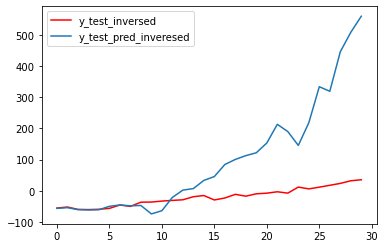

In [ ]:
%matplotlib inline
#plot
plt.plot(inv_y_test, color='red')
plt.plot(inv_y_pred)
 
plt.legend(['y_test_inversed','y_test_pred_inveresed'])
plt.show()


In [ ]:
print(rmse1, rmse2, rmse3, rmse4, rmse5, rmse6)

197.35814719517498 278.66354289717526 91.148194600544 107.49386233082606 25.281797759440643 192.8376247159282


In [ ]:
rmse = [rmse1, rmse2, rmse3, rmse4, rmse5, rmse6]
rmse

[197.35814719517498,
 278.66354289717526,
 91.148194600544,
 107.49386233082606,
 25.281797759440643,
 192.8376247159282]

In [ ]:
nrmse = [nrmse1, nrmse2, nrmse3, nrmse4, nrmse5, nrmse6]
nrmse

[-9.879936313953472,
 -13.95016165267305,
 -4.562965200998953,
 -5.381244853900859,
 -1.2656308103587215,
 -9.653634664715831]

In [ ]:
r2 = [r2_score1, r2_score2, r2_score3, r2_score4, r2_score5, r2_score6]
r2

[-48.87107940826576,
 -98.42576890781065,
 -9.63738287588392,
 -13.794693926129309,
 0.18162085178927034,
 -46.61263272734535]